<a href="https://colab.research.google.com/github/jjhurtadoa/Modelos-/blob/main/imbdreviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

Importación de librerías para el preprocesamiento y entrenamiento del modelo

In [ ]:
from importlib import  reload
import sys
from imp import  reload
import warnings
warnings.filterwarnings('ignore')

  
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
  
import re
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Cargamos el archivo en forma de dataframe, removemos las columnas que no nos interesan, dejamos solo las calificaciones positivas y negativas. Luego limpiamos el texto , eliminando signos de puntuación y carácteres especiales, volviendo minúsculas todas las palabras y lematizándolas.

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Tecno-Inclusion/MineriaTexto/Español_Analisis/imdb_master.csv',encoding="latin-1")
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
df = df.drop(['Unnamed: 0','type','file'],axis=1)
df.columns = ["review","sentiment"]
df = df[df.sentiment != 'unsup']
df['sentiment'] = df['sentiment'].map({'pos': 1, 'neg': 0})
  
 
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if  not word in stop_words]
    text = " ".join(text)
    return text
  
df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))
df.head()

,review,sentiment,Processed_Reviews
0,Once again Mr. Costner has dragged out a movie...,0,mr costner ha drag movie far longer necessary ...
1,This is an example of why the majority of acti...,0,example majority action film generic bore real...
2,"First of all I hate those moronic rappers, who...",0,first hate moronic rapper couldnt act gun pres...
3,Not even the Beatles could write songs everyon...,0,even beatles could write song everyone like al...
4,Brass pictures (movies is not a fitting word f...,0,brass picture movie fit word really somewhat b...


In [ ]:
len(df)

50000

Revisamos la media de las reseñas preprocesadas para tener un tamaño de referencia

In [ ]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()
128.51009333333334

128.51009333333334

Creamos el tokenizador con un alcance de 6000 palabras, y codificamos nuestros textos

In [ ]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])
  
RNN_CELL_SIZE = 32
  
MAX_LEN = 130  # Since our mean length is 128.5
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = df['sentiment']

# Create  Layers

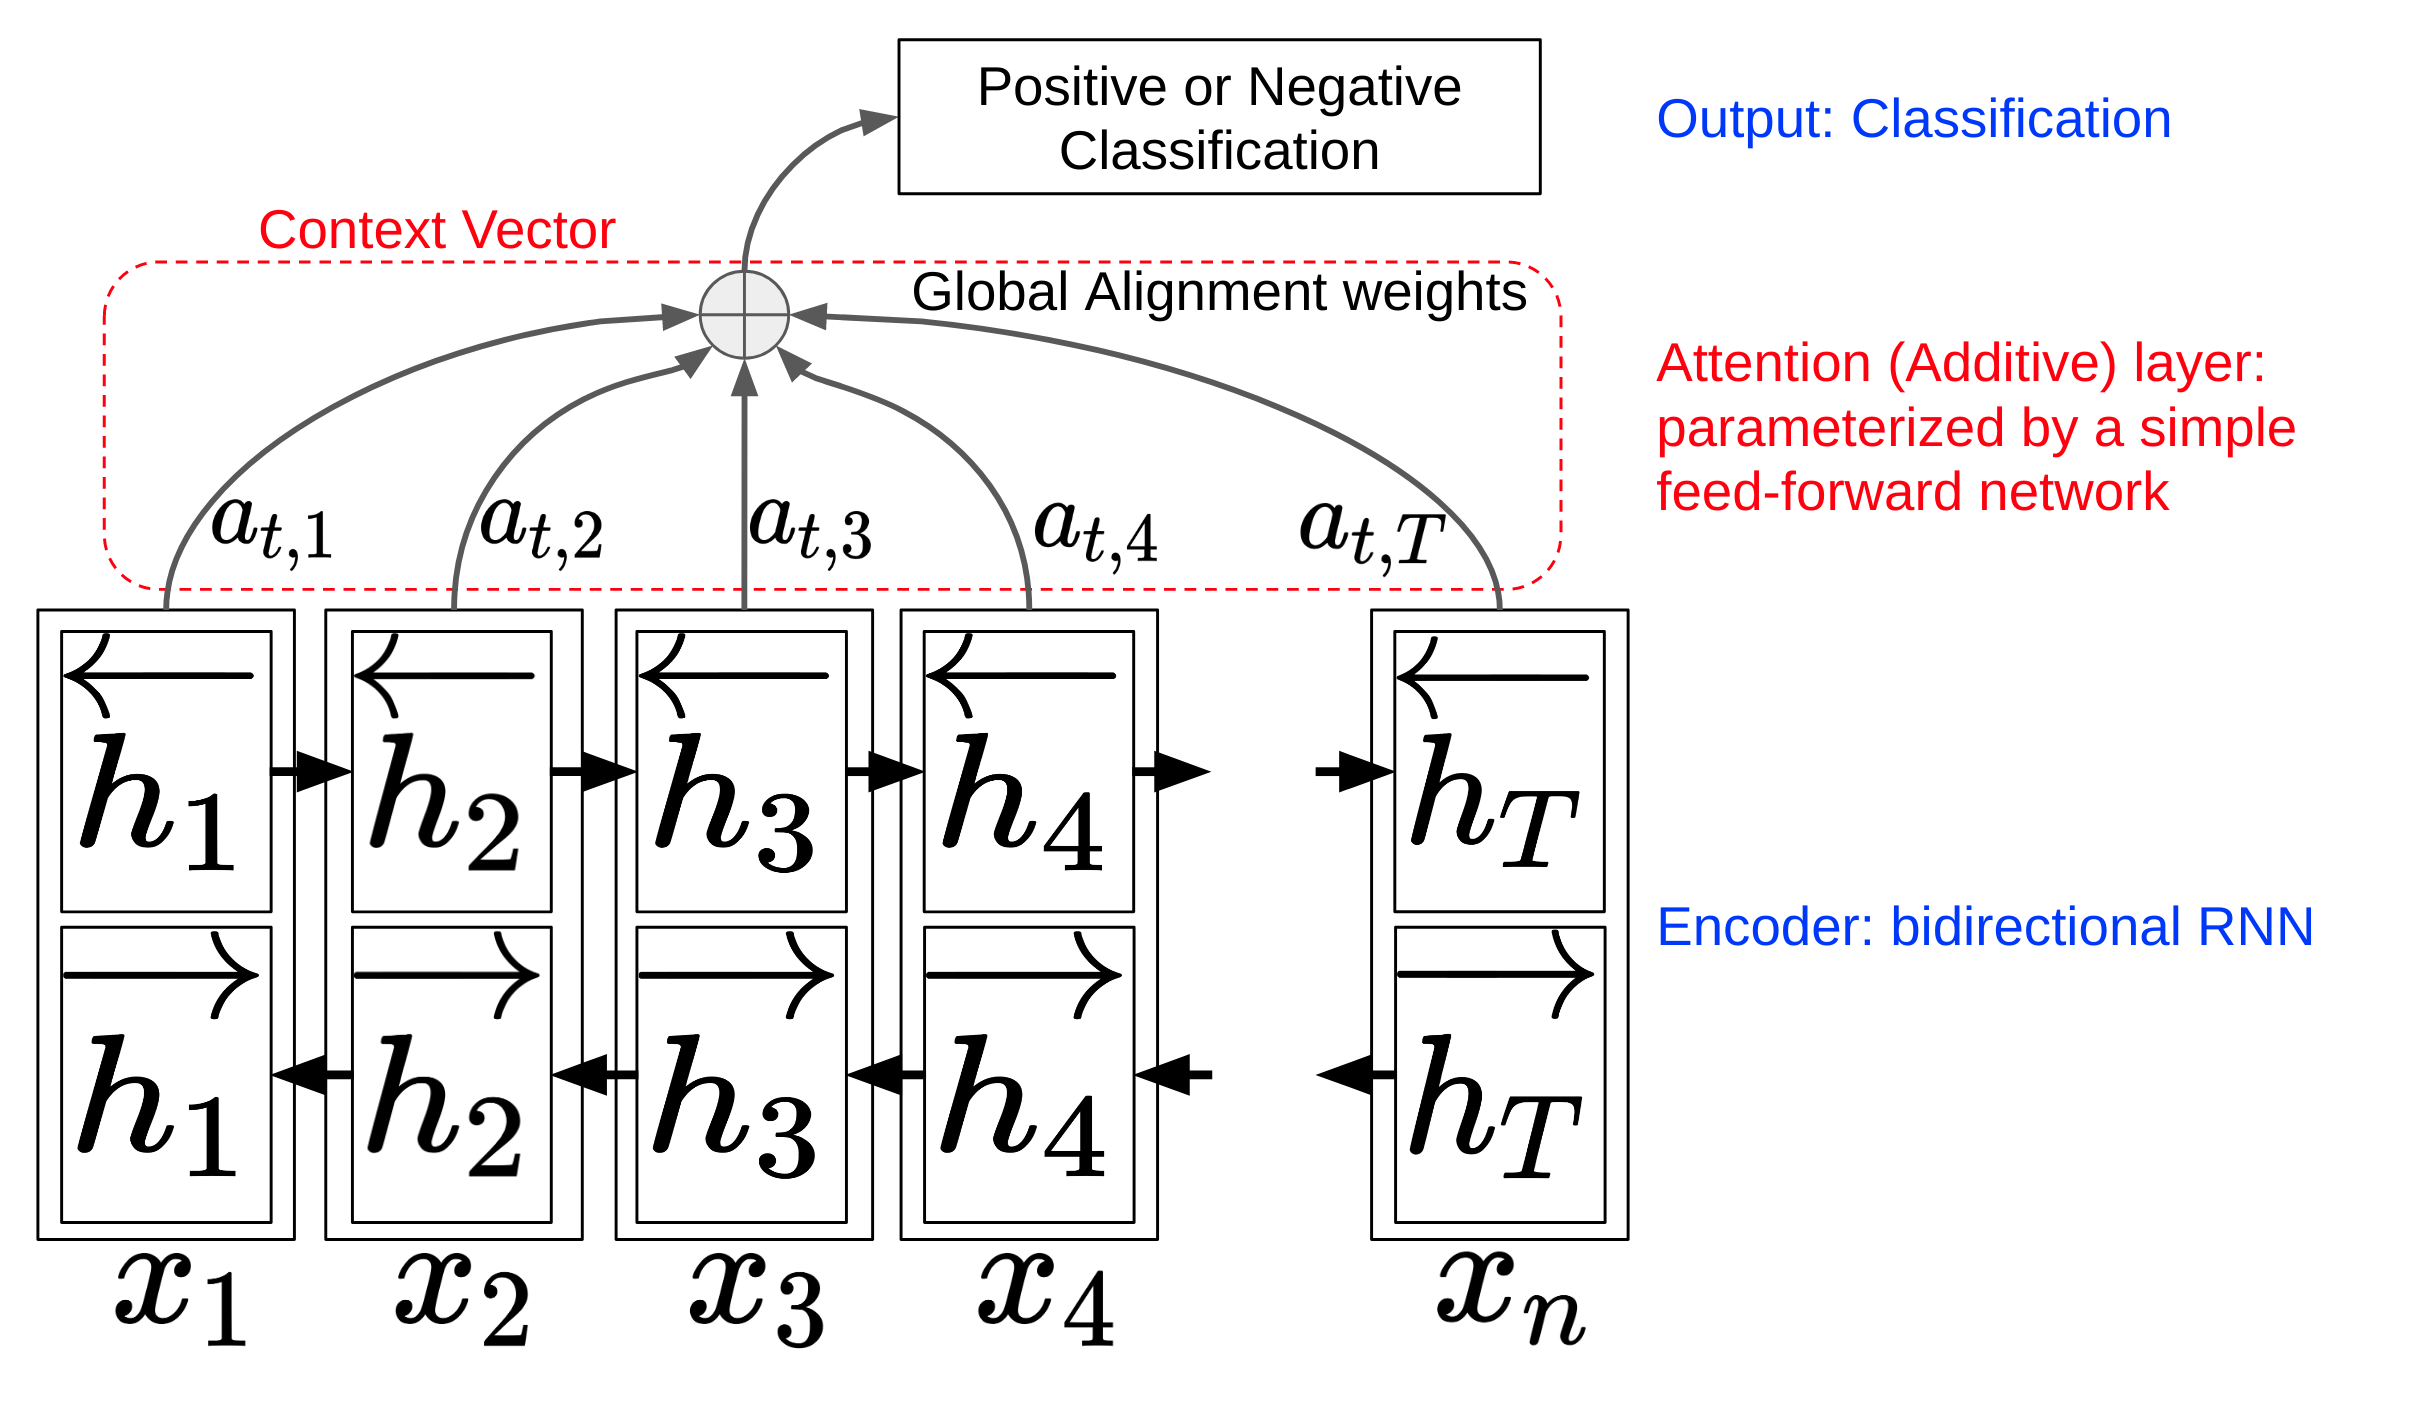

Se crea la función de atención para una red neuronal recurrente, para mantener información relevante de los estados de las salidas de cada celda RNN. Luego se usan esos etados para hacer una suma ponderada con la que se ejecuta la predicción.

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

Esta capa de atención es simple pero poderosa. Contiene capas de densidad sumadas en un función tanh, para calcular los pesos de atención y seguido a eso el vector de contexto

Creamos las capas necesarias para el modelo

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

Y se echa un vistazo a el resumen del modelo

In [ ]:
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 130, 128)     768000      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 130, 64)      41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 130, 64), (N 24832       bi_lstm_0[0][0]                  
______________________________________________________________________________________________

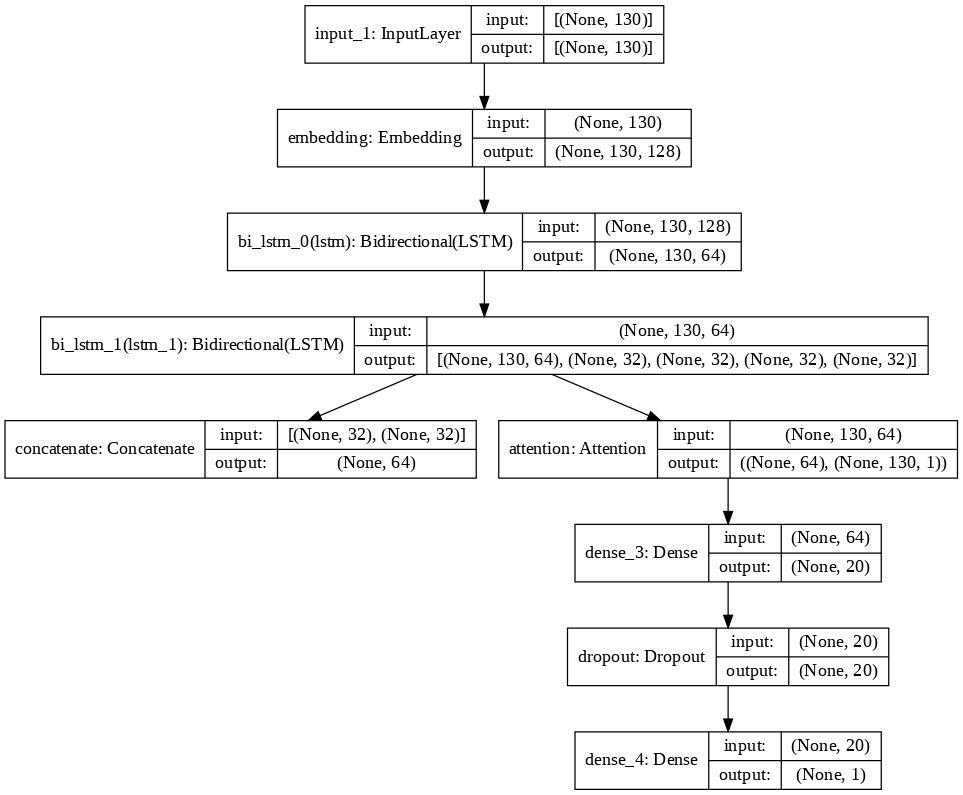

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

Compilamos el modelo y decidimos cuáles métricas queremos saber durante el entrenamiento

In [ ]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

Entrenamiento del modelo, con 5 epochs es suficiente para tener buenos resultados

In [ ]:
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)


Epoch 1/5
400/400 [==============================] - 153s 362ms/step - loss: 0.3378 - tp: 11074.0000 - fp: 2174.0000 - tn: 22826.0000 - fn: 3926.0000 - accuracy: 0.8475 - precision: 0.8359 - recall: 0.7383 - auc: 0.9233 - val_loss: 0.2911 - val_tp: 8755.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 1245.0000 - val_accuracy: 0.8755 - val_precision: 1.0000 - val_recall: 0.8755 - val_auc: 0.0000e+00
Epoch 2/5
400/400 [==============================] - 142s 354ms/step - loss: 0.2137 - tp: 13220.0000 - fp: 1610.0000 - tn: 23390.0000 - fn: 1780.0000 - accuracy: 0.9153 - precision: 0.8914 - recall: 0.8813 - auc: 0.9698 - val_loss: 0.5727 - val_tp: 7816.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 2184.0000 - val_accuracy: 0.7816 - val_precision: 1.0000 - val_recall: 0.7816 - val_auc: 0.0000e+00
Epoch 3/5
400/400 [==============================] - 143s 358ms/step - loss: 0.1629 - tp: 13674.0000 - fp: 1177.0000 - tn: 23823.0000 - fn: 1326.0000 - accuracy: 0.9374 - precisi

Testeamos el modelo, para esto es necesario preprocesar el conjunto de test

In [ ]:
# Loading the test dataset, and repeating the processing steps
df_test=pd.read_csv("/content/drive/MyDrive/Tecno-Inclusion/MineriaTexto/Español_Analisis/testData.tsv",header=0, delimiter="\t", quoting=3)
df_test.head()
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1  if  int(x.strip('"').split("_")[1]) >= 5  else  0)
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)
  
## Making predictions on our model
prediction = model.predict(X_test)
y_pred = [1 if (x > 0.5) else 0 for x in prediction]

In [ ]:
y_pred[:5]

[1, 0, 0, 0, 1]

In [ ]:
df_test.review[:5]

0    naturally film main theme mortality nostalgia ...
1    movie disaster within disaster film full great...
2    movie kid saw tonight child love one point kid...
3    afraid dark leave impression several different...
4    accurate depiction small time mob life film ne...
Name: review, dtype: object

In [ ]:
y_test

0        1
1        0
2        0
3        0
4        1
        ..
24995    1
24996    1
24997    0
24998    1
24999    1
Name: sentiment, Length: 25000, dtype: int64

Evaluación del modelo

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     12500
           1       0.99      0.98      0.98     12500

    accuracy                           0.98     25000
   macro avg       0.98      0.98      0.98     25000
weighted avg       0.98      0.98      0.98     25000



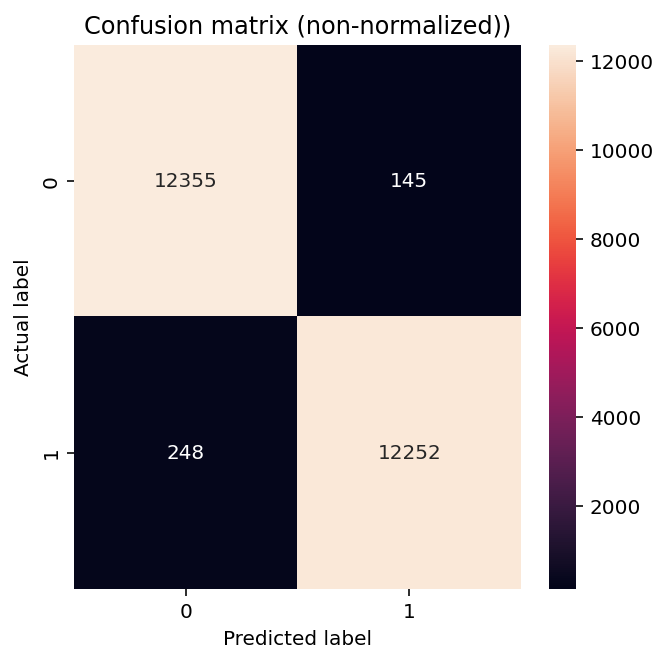

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(y_test, y_pred)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
  
plot_cm(y_test, y_pred)

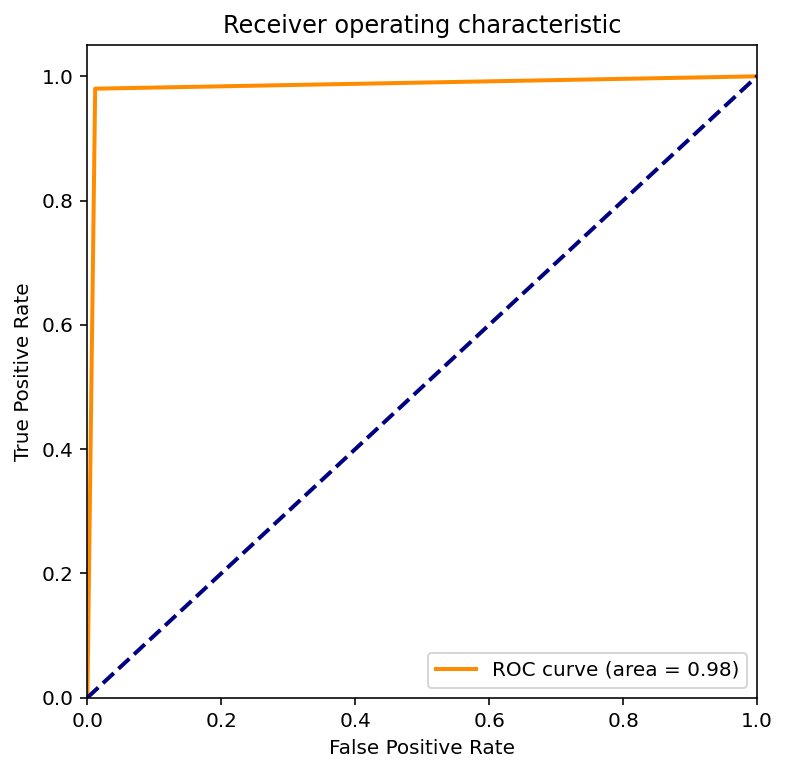

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
  
mpl.rcParams["figure.figsize"] = (6, 6)
  
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score
  
# Binarize the output
y_bin = label_binarize(y_test, classes=[0, 1])
n_classes = 1
  
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in  range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
  
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
prediction2 = model.predict(X_test[:1])

# Translation

In [ ]:
pip install googletrans==4.0.0-rc1

     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 1.2 MB 11.0 MB/s 
     |████████████████████████████████| 42 kB 953 kB/s 
     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=d3f0f89069ddeb5e1e5cb304b2e464d5d6b63716d2258f1f9294a6b7b2a19898
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans


Traducción de frases y evaluación del modelo con frases propias

In [ ]:
from googletrans import Translator
translator = Translator()
translation = translator.translate("Me gustan las películas de acción. Tengo una debilidad por las películas con diálogos malos y actuaciones de mala calidad. Así que me he devanado los sesos para encontrar uno de mis placeres culpables que fuera peor que esta superproducción. No puedo. Es difícil encontrar un pedazo de mierda más grande que este vehículo de Bruce Willis. Armageddon es la historia (y uso este término de forma imprecisa) de un equipo de \"Superperforadores\" que vuelan para destruir un asteroide antes de que destruya la Tierra. ¿Es realista? La verdad es que no. ¿Pero a quién le importa? Es una película de acción. La película comienza con un par de escenas diseñadas para presentar la amenaza y los personajes. Bruce Willis es el líder más duro del equipo, y pasa su primer tiempo en pantalla persiguiendo a Ben Affleck con una pistola por el imperdonable acto de acostarse con su hija. Por alguna razón, eso no me hizo reír. El equipo es llamado porque son las únicas personas en todo el mundo que pueden perforar el asteroide. Vale, estoy dispuesto a aceptar esa premisa si nos lleva a la acción, el supuesto meollo de la película. Más intentos de humor, con cada personaje saliendo a hacer alguna locura antes de despegar. Una vez más, es una lástima. Finalmente, despegan. Aquí es donde la película realmente me ha hecho polvo. Llegan a la roca y se ponen a trabajar. ¿Te lo puedes creer? ¡¡¡Nada funciona bien y todo tiene una cuenta atrás de suspenso!!! ¡Whoah! Diez, nueve, ocho... uno... ¡Oh, sorpresa, hemos salvado el día otra vez! Y no me hagas hablar de la cámara espasmódica. Cuando la vi en el cine pensé que me iba a enfermar. Sólo puedo suponer que intentaban tapar los enormes agujeros dejados por las insípidas interpretaciones cortando a un plano diferente cada pocos segundos (y esto lo dice alguien criado en la MTV, el mismo señor de la poca atención).Justo cuando pensaba que no podía ser peor... esperen, hay un final lacrimógeno fabricado que estaba tan hilvanado que hacía que el resto de la película fuera prácticamente Ciudadano Kane.Resumen: Las ocurrencias no eran ingeniosas. La trama... bueno, ya dije que la dejaría pasar. La actuación fue mala. Realmente mala. Ni siquiera Billy Bob pudo superar el guión, que era peor. El trabajo de cámara - de nuevo, malo. (Ni siquiera he mencionado la escena de amor más tonta de la historia del cine - piensa en las galletas de animales).Valoración: 1 de 10. (Doy medio punto por Steve Buscemi, que me hace sonreír en contra de mi voluntad y otro medio punto por las veces que pude mirar a la encantadora Liv Tyler e intentar ignorar su actuación) Esta es, de lejos, la peor película que he ido a ver al cine... nunca." , dest='en')
print(translation.text)
lista= []
lista.append(translation.text)
lista= [clean_text(x) for x in lista]
print(lista)
tokenized_translation = tokenizer.texts_to_sequences(lista)
test_translation = pad_sequences(tokenized_translation, maxlen=MAX_LEN)
prediction = model.predict(test_translation)
print( prediction)
if ( prediction > 0.5) : print("POSITIVO")
else: print("NEGATIVO")

print(test_translation)

I like action movies. I have a weakness for movies with bad dialogues and poor quality performances. So I've changed my brains to find one of my pleasses guilty that it was worse than this overproduction. Can not. It is difficult to find a piece of shit bigger than this Bruce Willis vehicle. Armageddon is the story (and use this term in an imprecise way) of a team of "superperforpers" that fly to destroy an asteroid before destroying the land. Is it realistic? The truth is, no. But who cares? It's an action film. The film begins with a couple of scenes designed to present the threat and the characters. Bruce Willis is the toughest leader of the team, and passes his first time on the screen chasing Ben Affleck with a gun for the unforgious act of lying down with his daughter. For some reason, that did not make me laugh. The team is called because they are the only people around the world who can drill the asteroid. Okay, I am willing to accept that premise if it takes us to action, the 

In [ ]:
from googletrans import Translator
translator = Translator()
translation = translator.translate("La película fue muy mala", dest='en')
print(translation.text)
lista= []
lista.append(translation.text)
lista= [clean_text(x) for x in lista]
print(lista)
tokenized_translation = tokenizer.texts_to_sequences(lista)
test_translation = pad_sequences(tokenized_translation, maxlen=MAX_LEN)
prediction = model.predict(test_translation)
print( prediction)
if ( prediction > 0.5) : print("POSITIVO")
else: print("NEGATIVO")

print(test_translation)

The movie was very bad
['movie wa bad']
[[0.4146024]]
NEGATIVO
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  2  3 30]]


In [ ]:
from googletrans import Translator
translator = Translator()
translation = translator.translate("La película es muy buena, me entretuvo mucho tiempo", dest='en')
print(translation.text)
lista= []
lista.append(translation.text)
lista= [clean_text(x) for x in lista]
print(lista)
tokenized_translation = tokenizer.texts_to_sequences(lista)
test_translation = pad_sequences(tokenized_translation, maxlen=MAX_LEN)
prediction = model.predict(test_translation)
print( prediction)
if ( prediction > 0.5) : print("POSITIVO")
else: print("NEGATIVO")

print(test_translation)

The movie is very good, I entertained a lot of time
['movie good entertain lot time']
[[0.92663974]]
POSITIVO
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2
   12 316  68  11]]


In [ ]:
from googletrans import Translator
translator = Translator()
translation = translator.translate("Este tipo de libros me gusta mucho, lo recomiendo", dest='en')
print(translation.text)
lista= []
lista.append(translation.text)
lista= [clean_text(x) for x in lista]
print(lista)
tokenized_translation = tokenizer.texts_to_sequences(lista)
test_translation = pad_sequences(tokenized_translation, maxlen=MAX_LEN)
prediction = model.predict(test_translation)
print( prediction)
if ( prediction > 0.5) : print("POSITIVO")
else: print("NEGATIVO")

print(test_translation)

This kind of books I like a lot, I recommend it
['kind book like lot recommend']
[[0.5389309]]
POSITIVO
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 145
  161   7  68 227]]


In [ ]:
from googletrans import Translator
translator = Translator()
translation = translator.translate("Este episodio fue probablemente el mejor de toda la serie porque es emocionante durante todo el visionado, no hay una sola parte de este episodio que sea aburrida. También hay que destacar a Esther Martínez Lobato por incorporar las emociones tan bien a lo largo del episodio.", dest='en')
print(translation.text)
lista= []
lista.append(translation.text)
lista= [clean_text(x) for x in lista]
print(lista)
tokenized_translation = tokenizer.texts_to_sequences(lista)
test_translation = pad_sequences(tokenized_translation, maxlen=MAX_LEN)
prediction = model.predict(test_translation)
print( prediction)
if ( prediction > 0.5) : print("POSITIVO")
else: print("NEGATIVO")

print(test_translation)

This episode was probably the best of the whole series because it is exciting throughout the viewing, there is not a single part of this episode that is boring.We must also highlight Esther Martínez Lobato for incorporating emotions so well throughout the episode.
['episode wa probably best whole series excite throughout view single part episode boringwe must also highlight esther martínez lobato incorporate emotion well throughout episode']
[[0.99512887]]
POSITIVO
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0